# Circular regression for eye detection

Here I will use a picture of an eye and don't try to detect the circular perimeter as an image but as a data distribution of points. The image will be binarized, go through border detection, then only the lower part of the borders will be kept, like a sonar from below. Afterwards, these reamining points will be sample data, no longer as pixels, but as a pair of coordinates of samples. Next, a semi-circle with the same number of points will be created with a starting center coordiantes and a radius. These variables will be optimized through a regression.  
tensorflow will be used for the border detection using a Laplacian filter and a convolution of it against the target image.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

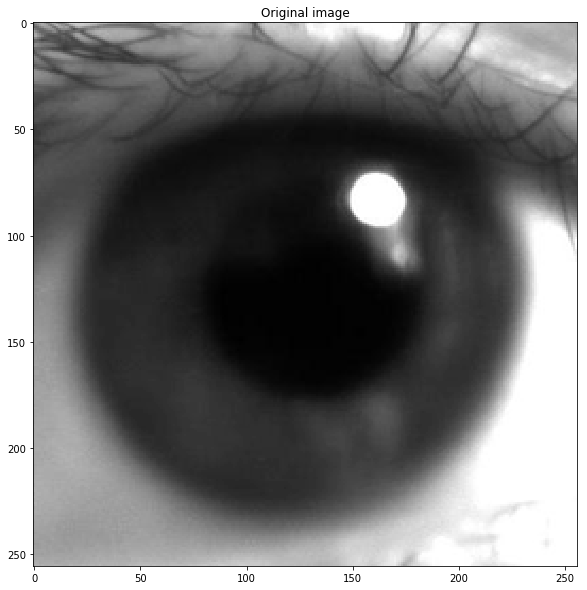

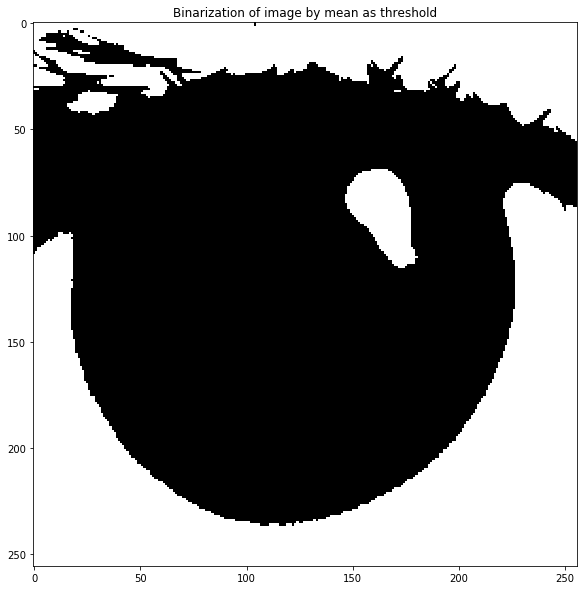

In [67]:
eye = 'ojo1.jpg'

eye = Image.open(eye)
eye = eye.resize((256,256),Image.ANTIALIAS)

eye = np.asarray(eye)

#Y' = 0.299 R + 0.587 G + 0.114 B 
#The image is already in grayscale, for converting a RGB image use these formula:
#eye = 0.299*eye[:,:,0]+0.587*eye[:,:,1]+0.114*eye[:,:,2]

fig = plt.figure(figsize=(10,10))
plt.imshow(eye,cmap='gray')
plt.title('Original image')
plt.show()

eye = eye.astype('float32')

#Binarize
eye[eye<eye.mean()]=-1
eye[eye>=eye.mean()]=1

fig = plt.figure(figsize=(10,10))
plt.imshow(eye,cmap='gray')
plt.title('Binarization of image by mean as threshold')
plt.show()

eyes = np.reshape(eye,(1,eye.shape[0],eye.shape[1],1))

## Border detection

In [31]:

x = tf.placeholder(tf.float32)

lag_filter = np.array([[1,1,1],[1,-8,1],[1,1,1]])
lgs = lag_filter.shape
lag_filter = np.reshape(lag_filter,(lgs[0],lgs[1],1,1))

conf_i = tf.nn.conv2d(x, lag_filter, strides=[1,1,1,1], padding='SAME')

init_op = tf.global_variables_initializer()
with tf.Session() as s:
    s.run(init_op)
    ri = s.run(conf_i,feed_dict={x:eyes})


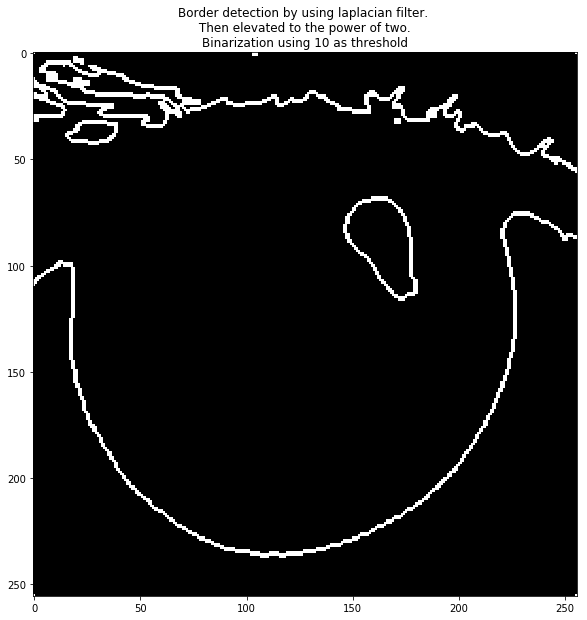

In [69]:
eyex = np.reshape(ri,eye.shape)
eyez = eyex**2
eyez[eyez>10]=255
eyez[eyez<=10]=0
fig = plt.figure(figsize=(10,10))
plt.imshow(eyez,cmap="gray")
plt.title('Border detection by using laplacian filter. \n Then elevated to the power of two. \nBinarization using 10 as threshold')
plt.show()

## Keep the lower points of the image and keep them as a data distribution

1


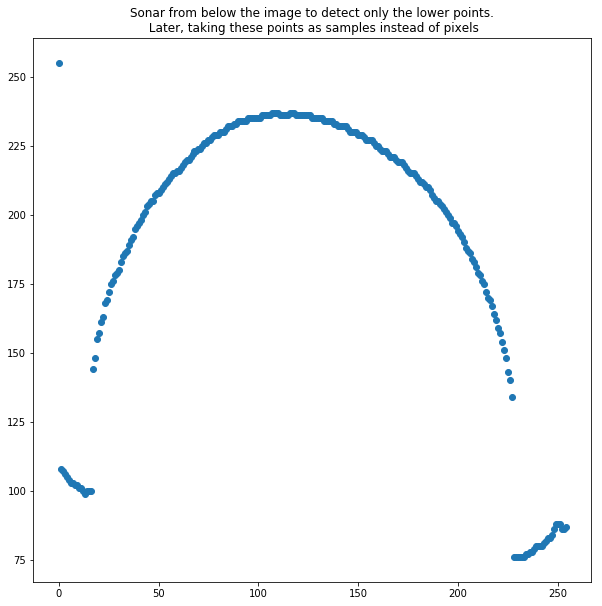

(255,) (255,)
(255, 1) (255, 1)


In [71]:
ny,nx = np.where(eyez>1)

maxv=[]
tj=0
tjv = 0
for _ in range(0,nx.max()):
    #print(nx==_)
    xb = nx==_
    xb = xb.astype(int)
    xbs = xb.sum()
    if xbs > 0 :
        mx = ny[nx==_].max()
        #print(mx)
        maxv.append(mx)
        if tj==0 and _!=0:
            tjv=_
            tj+=1
            print(tjv)
        

        
eye_low_y = np.asarray(maxv)
eye_low_x = np.arange(0,eye_low_y.shape[0])

fig = plt.figure(figsize=(10,10))
plt.scatter(eye_low_x,eye_low_y)
plt.title('Sonar from below the image to detect only the lower points.\n Later, taking these points as samples instead of pixels')
plt.show()

print(eye_low_x.shape,eye_low_y.shape)
eye_low_x = np.reshape(eye_low_x,(eye_low_x.shape[0],1))
eye_low_y = np.reshape(eye_low_y,(eye_low_y.shape[0],1))
print(eye_low_x.shape,eye_low_y.shape)
eye_low_xy = np.concatenate((eye_low_x,eye_low_y),1)

eye_xy_r = eye_low_xy.shape[0]


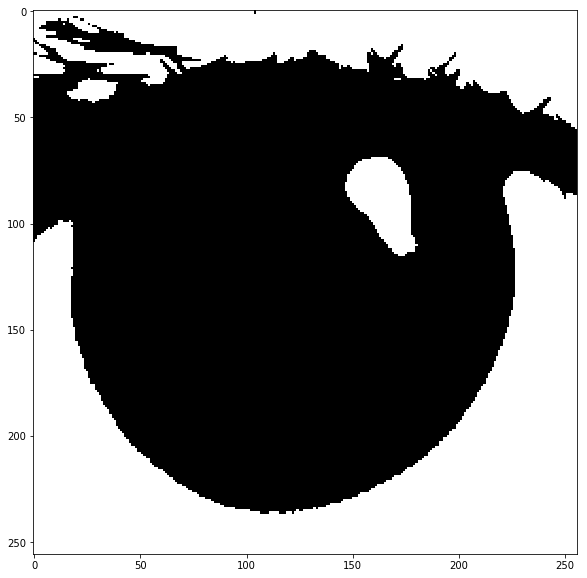

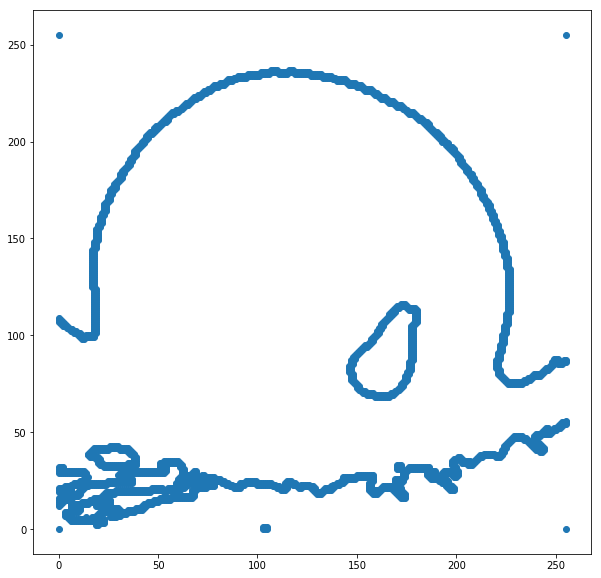

(2468, 2)


In [36]:
eye_y, eye_x = np.where(eyez>2)
fig = plt.figure(figsize=(10,10))
plt.scatter(eye_x, eye_y)
plt.show()

eye_xy = np.concatenate((np.reshape(eye_y,(eye_y.shape[0],1)),np.reshape(eye_x,(eye_y.shape[0],1))),1)
print(eye_xy.shape)


# Circular regression

**rc and rc2** are the radius of the circulare perimeter. if an ellipse is prefer set rc and rc2 for sinx and cosx respectively, otherwise, use only one for both.  
The circular perimeter to be created is centered at **pi**, so if the upper part of the circle is wanted set **thetha_diff** to 0.5. Set to 0.99 if a full circle is wanted.

50321.1
17703.9


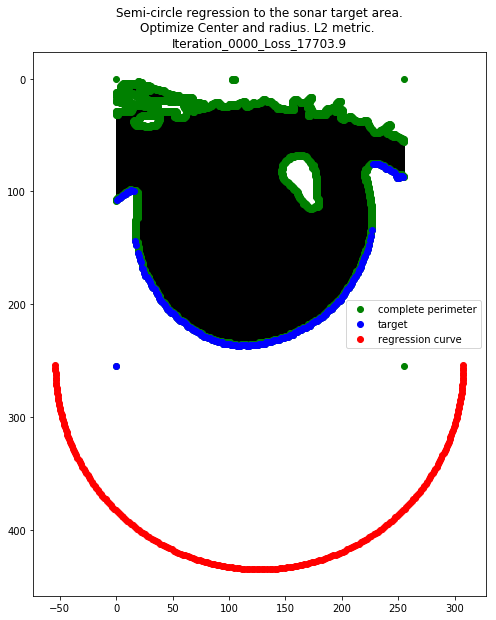

7340.67


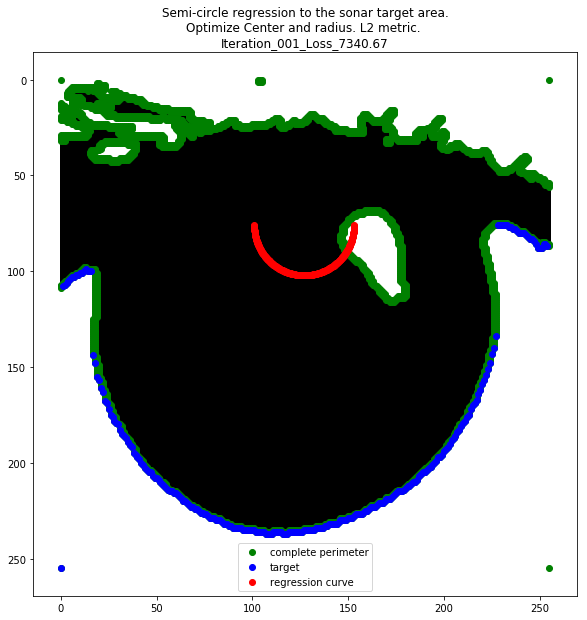

3173.58


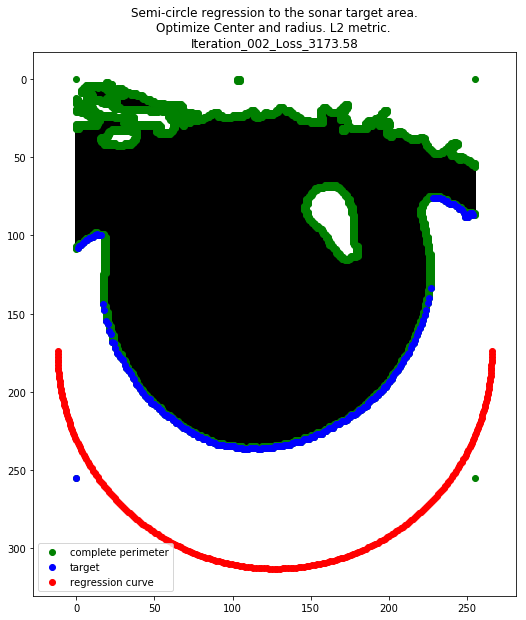

1497.99


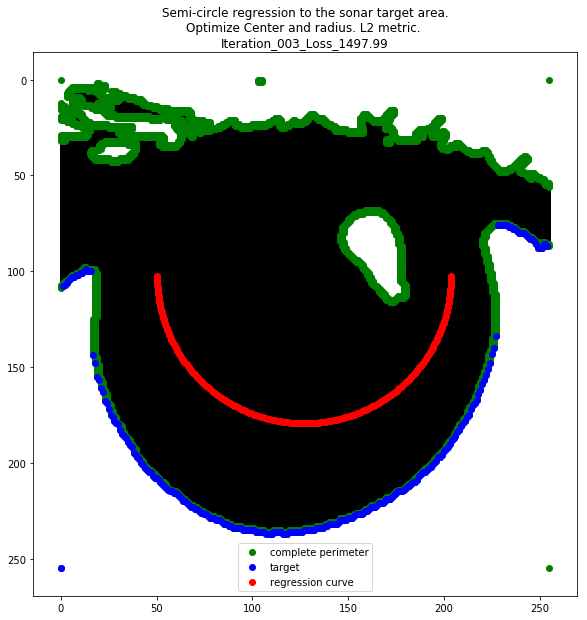

824.228


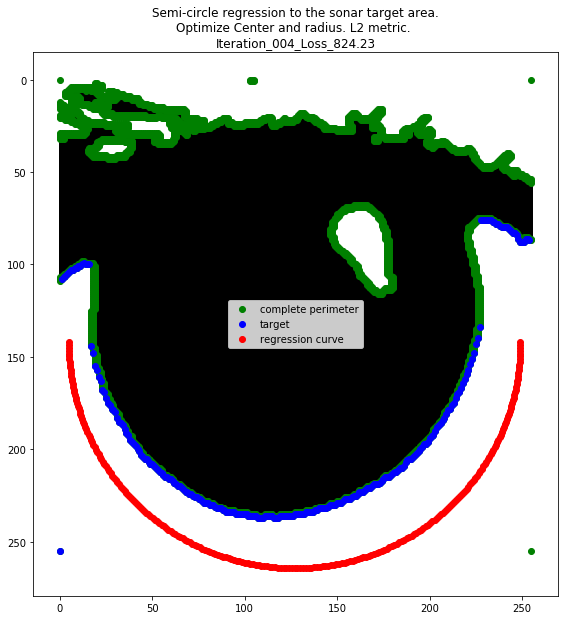

553.308


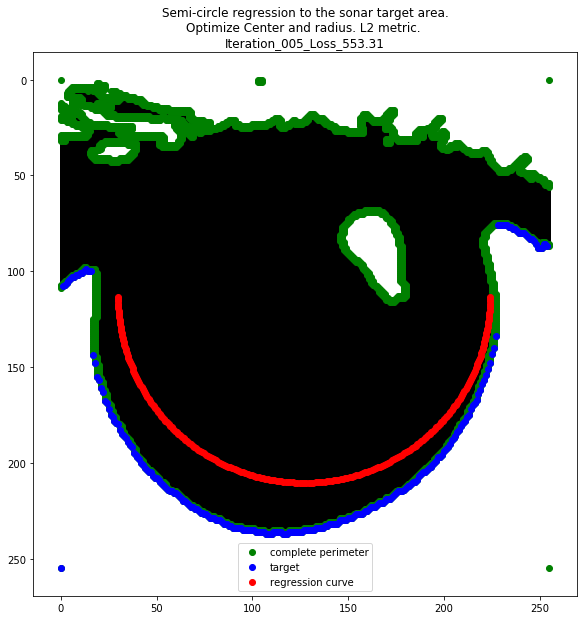

444.37


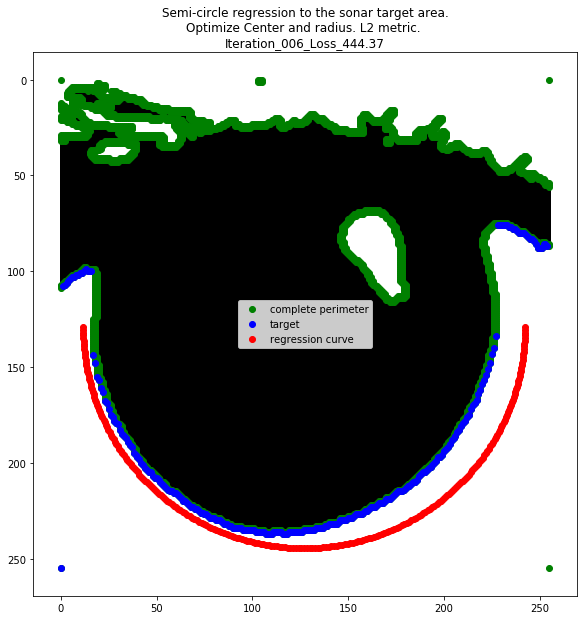

400.566


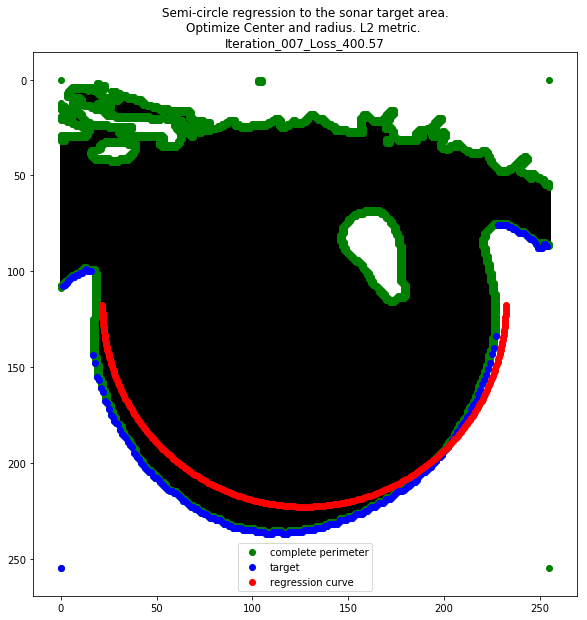

382.952


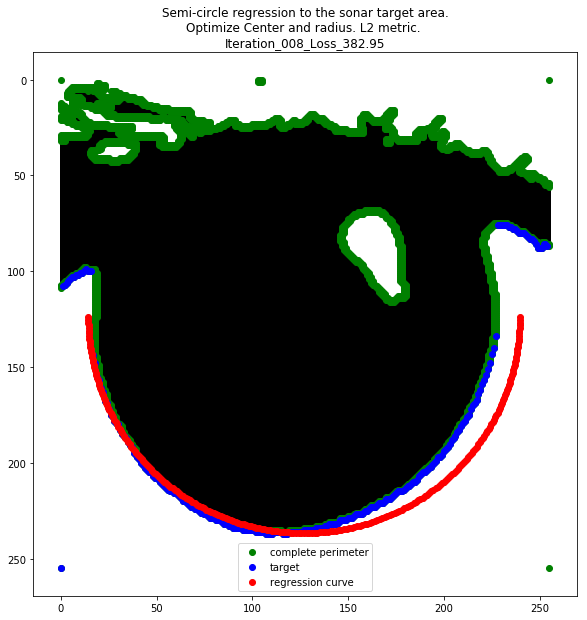

375.869


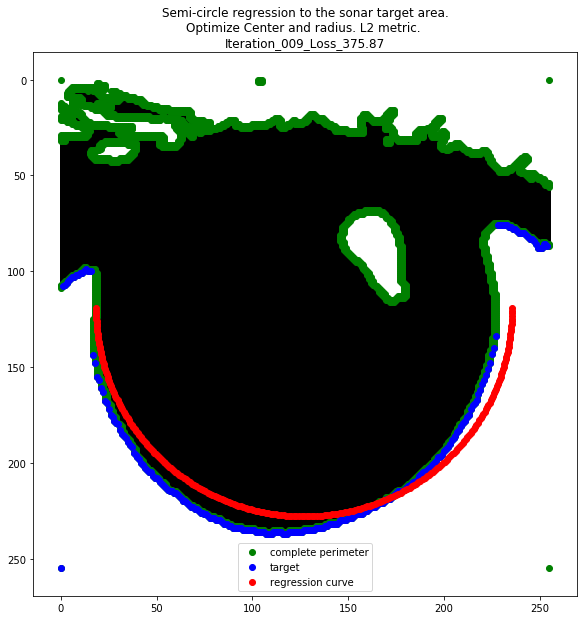

373.022


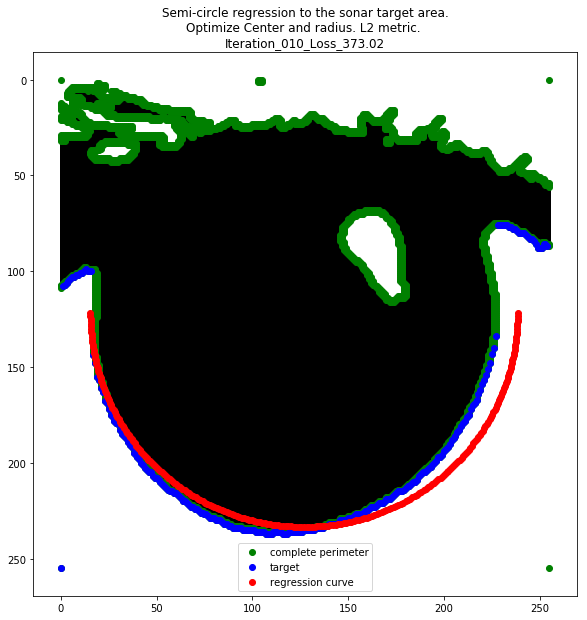

371.876


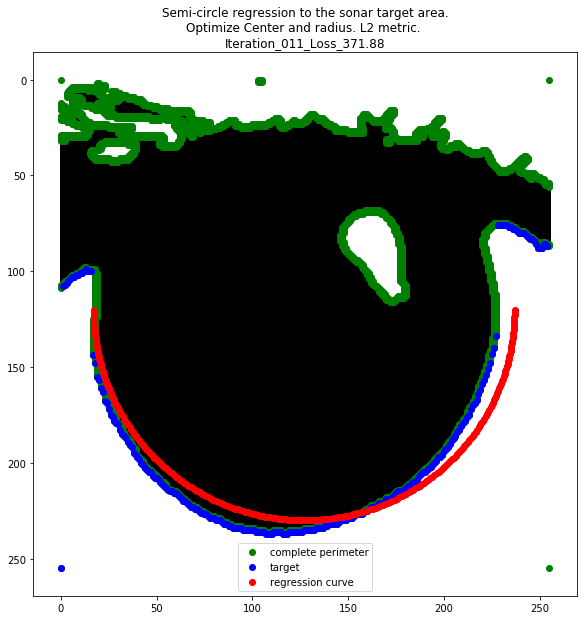

371.416


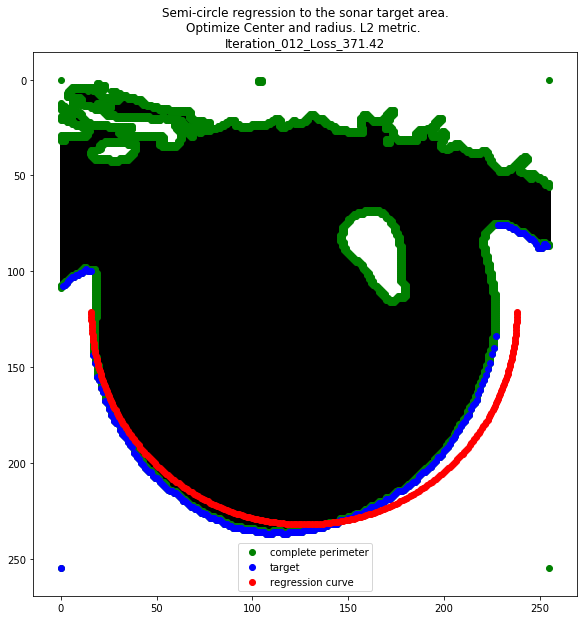

371.231


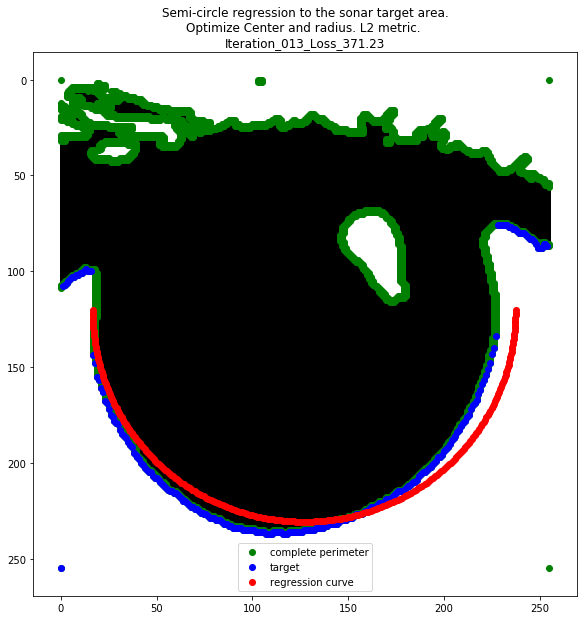

371.156


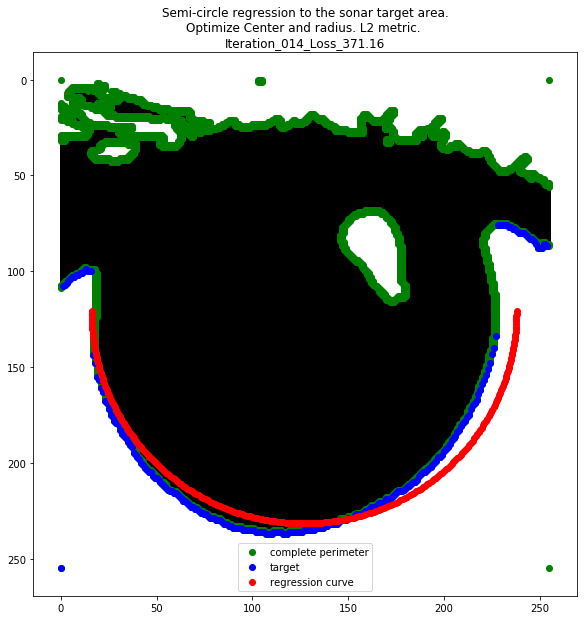

371.126


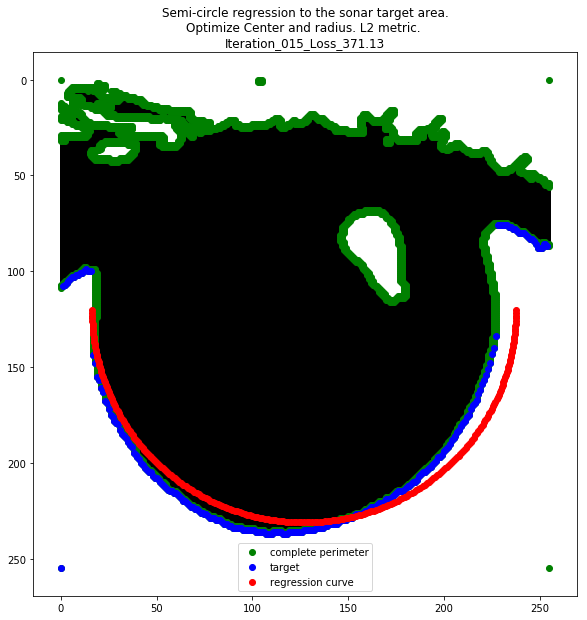

371.114


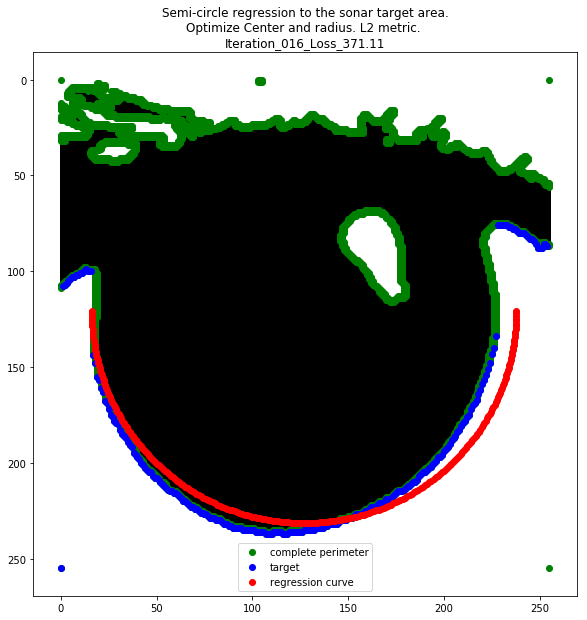

371.109


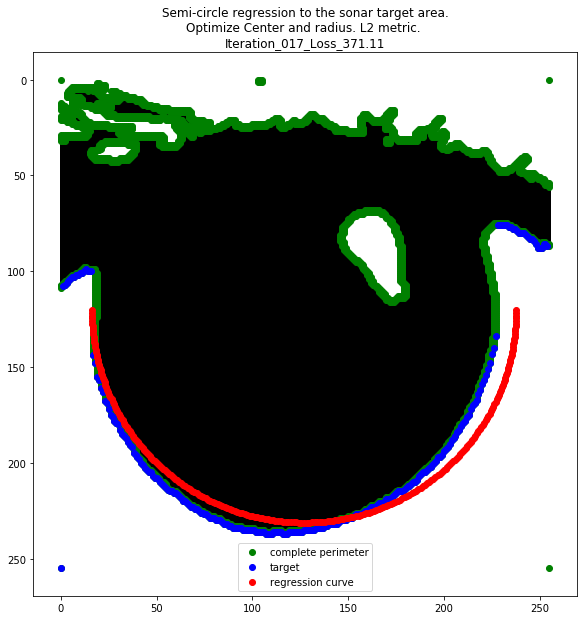

Convergence reached by value


In [72]:
xc=tf.Variable(10.0)
yc=tf.Variable(10.0)
rc=tf.Variable(100.0)
rc2=tf.Variable(100.0)

theta_diff = 0.5#0.45 

theta_low = np.pi*(1-theta_diff)
theta_up = np.pi*(1+theta_diff)

theta = np.linspace(theta_low,theta_up,eye_xy_r)


theta = np.reshape(theta,(theta.shape[0],1))

sinx = xc+rc*np.sin(theta)
#cosx = yc+rc2*np.cos(theta)
cosx = yc+rc*np.cos(theta)


sin_cos = tf.concat((sinx,cosx),1)

Xi = tf.placeholder(tf.float32)

loss = tf.reduce_mean(tf.squared_difference(sin_cos,Xi))

optimizer = tf.train.GradientDescentOptimizer(learning_rate=1)
train = optimizer.minimize(loss)


init_op = tf.global_variables_initializer()

iters=200
plot_result_f = 1
convergence_loss = 0.01

with tf.Session() as s:
    s.run(init_op)
    _,lb = s.run([train,loss],feed_dict={Xi:eye_low_xy})
    print(lb)
    
    for _ in range(0,iters):
        __,l,r = s.run([train,loss,sin_cos],feed_dict={Xi:eye_low_xy})
        
        if _%plot_result_f==0:
            print(l)
            
            fig = plt.figure(figsize=(10,10))
            plt.imshow(eye,cmap='gray')
            plt.scatter(eye_xy[:,1],eye_xy[:,0],color='green',label='complete perimeter')
            plt.scatter(eye_low_xy[:,0],eye_low_xy[:,1],color='blue',label='target')
            plt.scatter(r[:,0],r[:,1],color='red',label='regression curve')
            decp = np.floor(np.log10(iters))
            z=('0'*int((decp-(np.floor(np.log10(_+0.1))))))+str(_)
            title='Semi-circle regression to the sonar target area.\nOptimize Center and radius. L2 metric. \nIteration_'+z+'_Loss_'+str(np.round(l,2))

            plt.title(title)
            plt.legend()
            plt.show()
            fig.savefig('images/fig_04_'+z+'.png',dpi=80)
            if lb-l<convergence_loss:
                print("Convergence reached by value")
                break;
            lb=l
